[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvaroEkel/AI-Spielplatz/blob/main/Tutorials/Basics/App_template.ipynb)

# 🎨 AI Color Classifier – Supervised Learning as a basic ai-example
This interactive notebook demonstrates the core AI pipeline using **supervised learning**.
We’ll collect RGB data **with color labels**, train a neural network, and evaluate predictions.

🔁 **Steps:** Data Collection → Training → Evaluation (supervised classification)

In [6]:
# Installs libraries for the UI (Gradio), neural networks (PyTorch), and plotting (matplotlib)
!pip install gradio torch matplotlib scikit-learn

  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl (40.9 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 🔹 Step 1: Collect Labeled Color Data
Use the color picker and enter a label (like 'sky blue' or 'dark green').

In [4]:
import gradio as gr     # Gradio: simple Python UI library for building interactive web apps
import csv              # CSV: for saving data in table (comma-separated values) format
import os               # OS: for checking if file exists

csv_file = "color_data_rgb.csv"  # Name of the file where color data will be saved

# ✅ Create the CSV file with header row if it doesn't already exist
if not os.path.exists(csv_file):                     # Check if file already exists
    with open(csv_file, "w", newline="") as f:       # Open in write mode
        writer = csv.writer(f)                       # Create CSV writer
        writer.writerow(["r", "g", "b", "label"])    # Write header row: column names

# 🎨 Helper function: converts RGB values (0–255) into a hex color string (e.g., "#ff6600")
def rgb_to_hex(r, g, b):
    return f"#{int(r):02x}{int(g):02x}{int(b):02x}"  # Format RGB as 2-digit hex each

# 🔍 Create an HTML preview box that shows the selected RGB color
def update_preview(r, g, b):
    hex_color = rgb_to_hex(r, g, b)  # Convert RGB to hex string
    html = f"<div style='width:100%; height:100px; background-color:{hex_color}; border-radius:8px; border:1px solid #ccc'></div>"
    return html  # Return HTML to visually display the color

# 💾 Save the current color and its label to the CSV file
def save_data(r, g, b, label):
    if not label.strip():  # Prevent saving if label is empty
        return "Please enter a label."
    with open(csv_file, "a", newline="") as f:  # Open CSV in append mode
        writer = csv.writer(f)
        writer.writerow([int(r), int(g), int(b), label.strip().lower()])  # Write RGB + label to file
    return f"✅ Saved: RGB=({int(r)}, {int(g)}, {int(b)}) → Label='{label.strip().lower()}'"  # Feedback

# 🖼️ Build the Gradio interface
with gr.Blocks() as demo:
    # Title and instructions
    gr.Markdown("## 🎨 RGB Color Labeling\nUse the sliders to mix a color, label it, and save it to your dataset.")

    # RGB input sliders in a row
    with gr.Row():
        r = gr.Slider(0, 255, step=1, label="Red")     # Slider for Red value
        g = gr.Slider(0, 255, step=1, label="Green")   # Slider for Green value
        b = gr.Slider(0, 255, step=1, label="Blue")    # Slider for Blue value

    # HTML block to show live color preview
    preview = gr.HTML(label="Color Preview")

    # Update preview whenever a slider changes
    preview.change(fn=update_preview, inputs=[r, g, b], outputs=preview)
    r.change(fn=update_preview, inputs=[r, g, b], outputs=preview)
    g.change(fn=update_preview, inputs=[r, g, b], outputs=preview)
    b.change(fn=update_preview, inputs=[r, g, b], outputs=preview)

    # Input for user-defined label
    label = gr.Textbox(label="Color Label")

    # Button to trigger data saving
    save_button = gr.Button("💾 Save Color")

    # Textbox to show result message (success or error)
    output = gr.Textbox(label="Status")

    # Link the button to the save_data function
    save_button.click(fn=save_data, inputs=[r, g, b, label], outputs=output)

# 🚀 Launch the app
demo.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


**Task:** Go to Msty and let an LLM explain that code!

## 🔹 Step 2: Train the Classifier
We use a simple 3-layer neural network to classify colors by name.

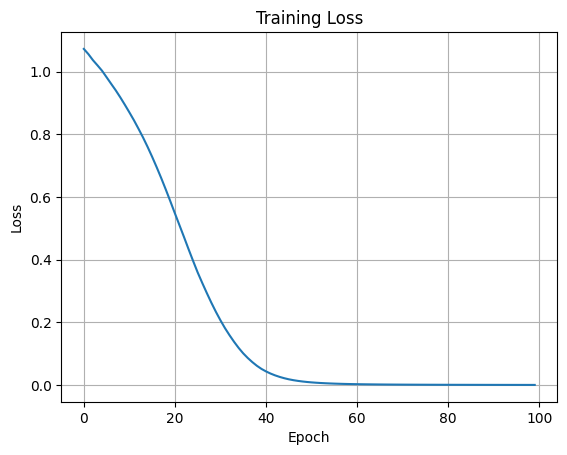

Model trained and saved.


In [9]:
# 🧠 Import required libraries for deep learning, preprocessing, and plotting
import torch                           # PyTorch: the core deep learning framework
import torch.nn as nn                  # Neural network module
import torch.optim as optim            # Optimizers for training
from sklearn.preprocessing import LabelEncoder  # For turning text labels into numbers
from sklearn.model_selection import train_test_split  # To split data into training/testing sets
import matplotlib.pyplot as plt        # To plot training progress
import numpy as np                     # For array/matrix operations
import pandas as pd                    # To read the color data from CSV

# 📥 Load the color data from CSV file
csv_file = "color_data_rgb.csv"        # CSV file where collected RGB+label data is stored
df = pd.read_csv(csv_file)             # Load data into a DataFrame

# 🛑 Check if we have enough data to train a model
if len(df) < 5:
    raise ValueError("Not enough labeled samples. Add more using the UI above.")

# 🎯 Extract RGB features and associated labels from the dataset
X = df[['r', 'g', 'b']].values.astype(np.float32) / 255.0  # Normalize RGB to range 0–1
labels = df['label'].values                                # Extract text labels (e.g. 'red')

# 🔠 Convert text labels into numeric class IDs
le = LabelEncoder()
y = le.fit_transform(labels)  # Turn label strings into class numbers (e.g. 'red' → 0)

# ✂️ Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔄 Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 🧠 Define a simple feedforward neural network
class ColorClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 16),       # Input layer: 3 neurons (R, G, B) → 16 neurons
            nn.ReLU(),              # ReLU introduces non-linearity
                                    # ReLU (Rectified Linear Unit) is an activation function
                                    # It outputs 0 for negative inputs, and passes positive inputs unchanged
                                    # This helps the network model complex patterns like curves or categories
            nn.Linear(16, 16),      # Hidden layer: 16 → 16 neurons
            nn.ReLU(),              # Another non-linearity
            nn.Linear(16, num_classes)  # Output layer: N neurons (N = number of unique labels)
        )

        # 🧠 Summary of network structure:
        # Input: 3 neurons for normalized RGB values
        # Hidden Layer 1: 16 neurons with ReLU activation
        # Hidden Layer 2: 16 neurons with ReLU activation
        # Output Layer: N neurons (one per class label)
        # Full architecture: 3 → 16 → 16 → N
        # Note: Each Linear layer is fully connected (dense)

    def forward(self, x):
        return self.model(x)  # Defines the forward computation through the network
        # This is a feedforward network:
        # - Data flows only forward from input → output
        # - Training adjusts the weights to reduce prediction error (via backpropagation)

# ⚙️ Create model, loss function, and optimizer
model = ColorClassifier(num_classes=len(le.classes_))  # Instantiate the model with correct output size
criterion = nn.CrossEntropyLoss()                      # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.01)    # Adam optimizer (adaptive learning rate)

# 🏋️ Training loop
losses = []
for epoch in range(100):                      # Train for 100 epochs
    optimizer.zero_grad()                     # Clear previous gradients
    outputs = model(X_train)                  # Forward pass: get predictions
    loss = criterion(outputs, y_train)        # Compute loss between predictions and true labels
    loss.backward()                           # Backward pass: calculate gradients
    optimizer.step()                          # Update weights based on gradients
    losses.append(loss.item())                # Store loss for visualization

# 📈 Plot the loss curve to see if training worked
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 💾 Save the trained model to file for future use
torch.save(model.state_dict(), "color_classifier.pt")
print("Model trained and saved.")


**Task:** Go to Msty and discuss the model / model architecture or knowledge with a LLM!


## 🔹 Step 3: Predict and Evaluate
Use the model to classify new colors.

In [11]:
# 🧠 Gradio interface for prediction using sliders and color preview

import gradio as gr

# Define a function that takes RGB sliders and returns a predicted label + color preview
def predict_label(r, g, b):
    rgb = torch.tensor([[r / 255.0, g / 255.0, b / 255.0]], dtype=torch.float32)  # Normalize RGB and convert to tensor

    model.eval()  # Set model to evaluation mode (disables things like dropout)
    with torch.no_grad():  # No need to track gradients during inference
        pred = model(rgb)  # Run the model to get output scores
        label_idx = torch.argmax(pred, dim=1).item()  # Get the index of the highest score (predicted class)

    predicted_label = le.classes_[label_idx]  # Get the label name from the label encoder

    # Build a small color box preview using HTML
    hex_color = f"#{int(r):02x}{int(g):02x}{int(b):02x}"  # Convert RGB to hex
    preview_html = f"<div style='width:100%; height:100px; background-color:{hex_color}; border-radius:8px; border:1px solid #ccc'></div>"

    return f"Predicted Label: {predicted_label}", preview_html  # Return prediction + visual preview

# Build the Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## 🎯 Test Color Classifier\nUse the sliders to choose a color and see how the model classifies it.")

    # RGB input sliders
    with gr.Row():
        r = gr.Slider(0, 255, step=1, label="Red")     # Slider for Red value
        g = gr.Slider(0, 255, step=1, label="Green")   # Slider for Green value
        b = gr.Slider(0, 255, step=1, label="Blue")    # Slider for Blue value

    # Output: Predicted label and color box
    prediction_output = gr.Textbox(label="Predicted Label")  # Text label output
    color_preview = gr.HTML(label="Color Preview")           # Visual color preview

    # Predict on change of sliders (live inference)
    r.change(fn=predict_label, inputs=[r, g, b], outputs=[prediction_output, color_preview])
    g.change(fn=predict_label, inputs=[r, g, b], outputs=[prediction_output, color_preview])
    b.change(fn=predict_label, inputs=[r, g, b], outputs=[prediction_output, color_preview])

demo.launch()  # 🚀 Launch the Gradio app


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


**Task:** Try the whole code on the Raspberry Pi!

**Task:** Check gradio docs for other I/O components!